In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install easyocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (3,255 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

In [119]:
import os
import glob

from pytesseract import Output
import pytesseract
import imutils
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
from pytesseract.pytesseract import TesseractError
import torch

%matplotlib inline
is_gpu = True if torch.cuda.is_available() else False
reader = easyocr.Reader(['pl'], gpu=is_gpu)


In [5]:
path_books = "./books/"
path_output = "./output/"
if os.path.exists(path_books)==False:
  os.mkdir(path_books)
if os.path.exists(path_output)==False:
  os.mkdir(path_output)

In [112]:
def list_image_paths(folder_path):
    # Create a list of all files with the extensions ".jpg" and ".png"
    files = glob.glob(os.path.join(folder_path, "*.jpg")) + glob.glob(os.path.join(folder_path, "*.png"))
    print(f"Number of files: {len(files)}")

    return files

In [113]:
img_paths = list_image_paths("./books/")

Number of files: 21


# Book rotation

In [83]:
def correct_rotation(img_path):
  img = cv2.imread(img_path)
  h, w, _ = img.shape
  if h < w:
    new_img = imutils.rotate_bound(img, -90)
  else:
    new_img = img

  cv2.imwrite(img_path, new_img)

### TODO
to img preprocessing add some function to variate the way of tresholding for different books (more/less visible?)

In [114]:
def img_preprocess(img_path):
  img = cv2.imread(img_path)
  img = (img * 255).astype("uint8")
  image_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  thresh = cv2.adaptiveThreshold(image_grey, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 151, 1)
  cv2.imwrite(img_path, thresh)

In [110]:
def check_upside_down(img_path):
  img = cv2.imread(img_path)
  org_img_text = reader.readtext(img)
  rotated_img = imutils.rotate_bound(img, 180)
  rotated_img_txt = reader.readtext(rotated_img)
  count_original = sum(len(element[-2])*element[-1] for element in org_img_text)
  count_rotated = sum(len(element[-2])*element[-1] for element in rotated_img_txt)


  if count_original < count_rotated:
    cv2.imwrite(img_path, rotated_img)

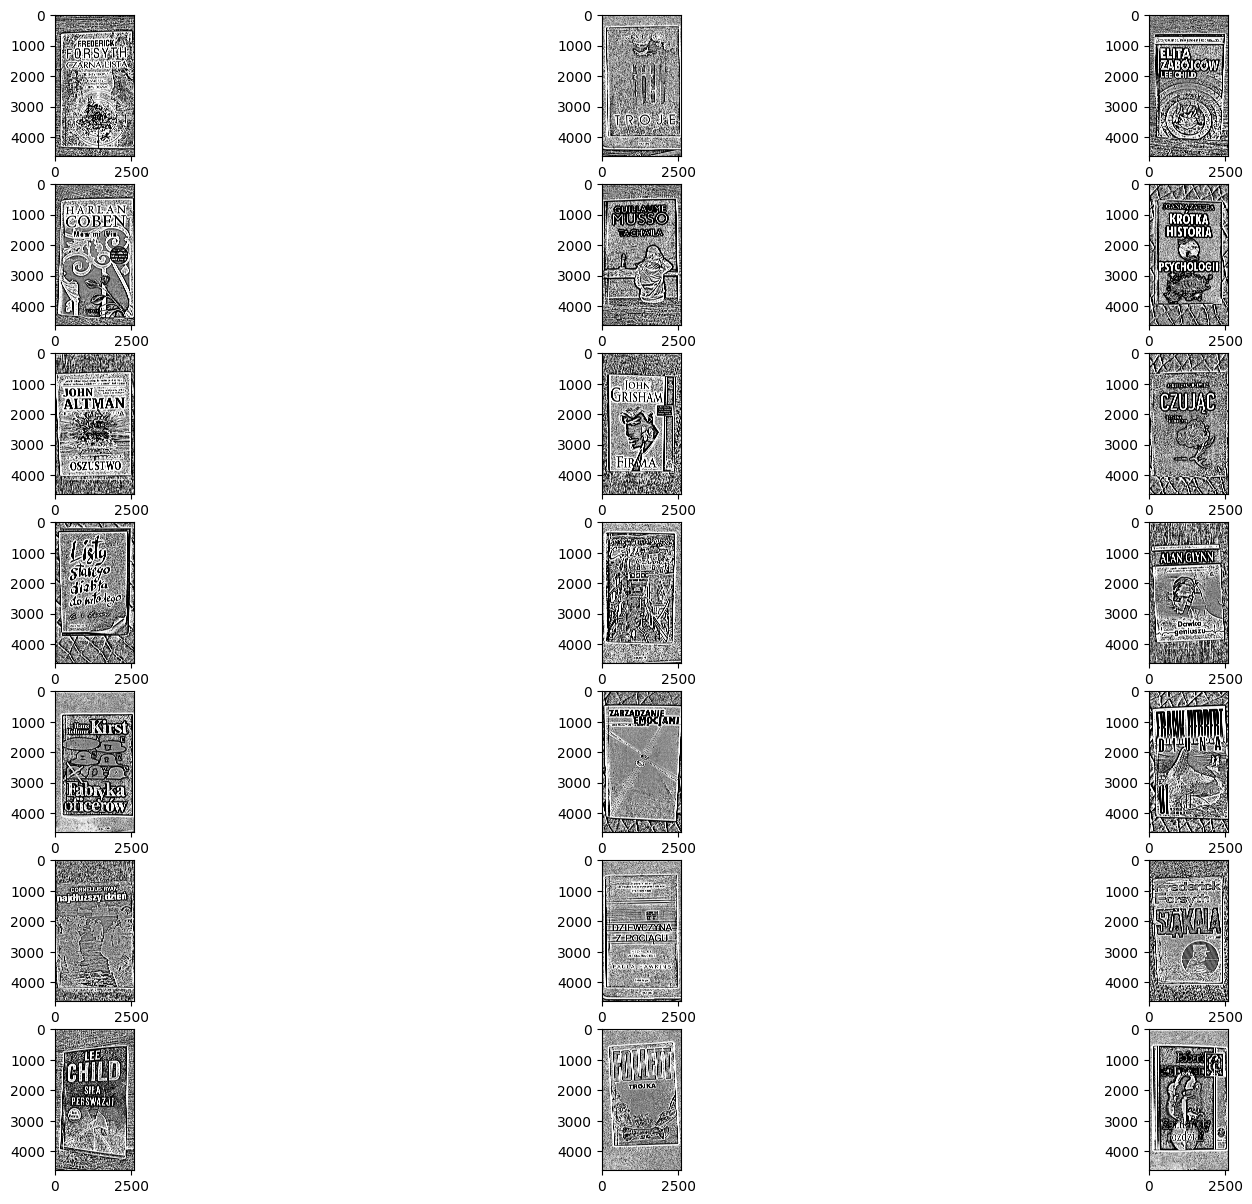

In [115]:
for img_path in img_paths:
  correct_rotation(img_path)
  img_preprocess(img_path)
  check_upside_down(img_path)
  
fig = plt.figure(figsize=(20, 15))
columns = round(len(img_paths)/3)
rows = round(len(img_paths)/columns)

for i in range(1, columns*rows+1):
    img = cv2.imread(img_paths[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Try easyOCR

In [116]:
def recognize_text(img_path):
    return reader.readtext(img_path)

In [117]:
def overlay_ocr_text(img_path):
    '''loads an image, recognizes text, and overlays the text on the image.'''
    # loads image
    img = cv2.imread(img_path)

    #dpi = 300
    #fig_width, fig_height = int(img.shape[0]/dpi), int(img.shape[1]/dpi)
    #plt.figure()
    #f, axarr = plt.subplots(1,2, figsize=(fig_width, fig_height)) 
    #axarr[0].imshow(img)
    
    # recognize text
    result = recognize_text(img_path)
    text_all = [img_path]

    # if OCR prob is over 0.5, overlay bounding box and text
    for (bbox, text, prob) in result:
        if prob >= 0.5:
            # display 
            text_all.append(text)
            print(f'Detected text: {text} (Probability: {prob:.2f})')

            # get top-left and bottom-right bbox vertices
            (top_left, top_right, bottom_right, bottom_left) = bbox
            top_left = (int(top_left[0]), int(top_left[1]))
            bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

            # create a rectangle for bbox display
            cv2.rectangle(img=img, pt1=top_left, pt2=bottom_right, color=(255, 0, 0), thickness=10)

            # put recognized text
            cv2.putText(img=img, text=text, org=(top_left[0], top_left[1] - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=8)
        
    # show and save image
    #axarr[1].imshow(img)
    filename = os.path.basename(img_path)
    #.savefig(f'./output/{filename}', bbox_inches='tight')
    return text_all

In [118]:
with open("text.txt", "w") as txt_file:
  for im_path in img_paths:
    text = overlay_ocr_text(im_path)
    text_str = '.'.join(text)
    txt_file.write(text_str)
    txt_file.write("\n")


Detected text: FORSYTH (Probability: 0.98)
Detected text: CZARNA (Probability: 0.88)
Detected text: LISTA (Probability: 1.00)
Detected text: ZIDENTYFIKOWAC: (Probability: 0.99)
Detected text: NAMIERZYC: (Probability: 0.87)
Detected text: T (Probability: 0.91)
Detected text: JE (Probability: 0.97)
Detected text: 1 (Probability: 0.90)
Detected text: k7oś WZIĄŁ NA CEL JACKA REACHERA (Probability: 0.66)
Detected text: JEGO PRZYJACIÓŁ (Probability: 0.99)
Detected text: ELIITA (Probability: 0.94)
Detected text: ZABOJG@W (Probability: 0.62)
Detected text: LEECHILD (Probability: 1.00)
Detected text: HARLAN (Probability: 1.00)
Detected text: ik (Probability: 0.72)
Detected text: Ekscentryczny (Probability: 1.00)
Detected text: przyjaciel Myrona (Probability: 1.00)
Detected text: Bolitara nareszcie (Probability: 0.87)
Detected text: 6 (Probability: 0.75)
Detected text: w roli głównej! (Probability: 0.66)
Detected text: A L B A T R (Probability: 0.67)
Detected text: GUILLAUME (Probability: 1.00)
